<a href="https://colab.research.google.com/github/will-hill/Yelp_NLP/blob/master/3.Basic_Keras_DL_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Keras Deep Learning NLP
inspired from 
* https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras
* https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff


### Will's Setup Code
I created a couple subdirectories in my Google Drive

In [0]:
# LAB
# REVIEW_FILE_JSON = 'review.json' 
# COLAB
# REVIEW_FILE_JSON = '/content/drive/My Drive/colab/yelp_nlp/review.json'

### Colab Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Joanna Setup Code

In [3]:
from google.colab import drive #python code
drive.mount('/content/drive') # python code <- follow the resulting directions
!ln -s drive/My\ Drive data # bash command
!ls # you should "see" drive directory now.
hd5_path='data/final_project_dl/reviews_100000.h5'
#!pip install numpy==1.15.4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link 'data/My Drive': Function not implemented
data  drive  sample_data


In [0]:
import pandas as pd
df = pd.read_hdf(hd5_path)
df=df[0:10000]

### create word index

In [0]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# From https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [0]:
df['text']=df['text'].apply(text_to_wordlist)

In [7]:
df['text'].head()

0    total bill for this horrible service over 8gs ...
1    i adore travis at the hard rock new kelly card...
2    i have to say that this office really has it t...
3    went in for a lunch steak sandwich was delicio...
4    today was my second out of three sessions i ha...
Name: text, dtype: object

In [8]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].values)
VOCAB_SIZE = len(tokenizer.word_index) + 1
del Tokenizer

Using TensorFlow backend.


In [9]:
VOCAB_SIZE

26201

### convert words to indices

In [0]:
X = tokenizer.texts_to_sequences(df.text.values)
del tokenizer

### add zeroes so all texts are same length

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X)
del pad_sequences

# Y/N Useful

In [12]:
# Mark as Useful if at least 1 "Useful" upvote. Else 0.
Y_useful_binary = df.useful.apply(lambda x: 1 if x > 0 else 0)

from sklearn.model_selection import train_test_split

X_train_useful_binary, X_test_useful_binary, Y_train_useful_binary, Y_test_useful_binary = train_test_split(X,Y_useful_binary, test_size = 0.33, random_state = 42)
print(X_train_useful_binary.shape,Y_train_useful_binary.shape)
print(X_test_useful_binary.shape,Y_test_useful_binary.shape)

del train_test_split

(6700, 963) (6700,)
(3300, 963) (3300,)


In [13]:
Y_useful_binary.value_counts() # Positive and negative class are relatively even

0    5409
1    4591
Name: useful, dtype: int64

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D
from keras import regularizers 

OUTPUT_DIM = 64 #128
LSTM_OUT = 64 #196

model_useful_binary = Sequential()
model_useful_binary.add(Embedding(VOCAB_SIZE, 
                    OUTPUT_DIM, 
                    mask_zero=True,
                    input_length = X_train_useful_binary.shape[1]))

model_useful_binary.add(Dropout(0.5))

model_useful_binary.add(LSTM(LSTM_OUT,
               dropout=0.4,
               recurrent_dropout=0.4,
               return_sequences=True,
               kernel_regularizer=regularizers.l2(0.01)))

model_useful_binary.add(LSTM(int(LSTM_OUT/2.0),
               dropout=0.5,
               recurrent_dropout=0.5,
               return_sequences=False,
               kernel_regularizer=regularizers.l2(0.01)))

model_useful_binary.add(Dropout(0.5))

model_useful_binary.add(Dense(8))
model_useful_binary.add(Dense(1,activation='sigmoid'))

model_useful_binary.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['mse','accuracy'])
print(model_useful_binary.summary())


W0804 15:49:14.420320 140186473191296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 15:49:14.438320 140186473191296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 15:49:14.440652 140186473191296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 15:49:14.454950 140186473191296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 15:49:14.464320 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 963, 64)           1676864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 963, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 963, 64)           33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total para

In [15]:
%%time
batch_size = 256
epochs = 10
history_useful_binary = model_useful_binary.fit(X_train_useful_binary, Y_train_useful_binary, validation_split=0.333, epochs = epochs, batch_size=batch_size, verbose = 2)

Train on 4468 samples, validate on 2232 samples
Epoch 1/10
 - 90s - loss: 2.2856 - mean_squared_error: 0.2485 - acc: 0.5372 - val_loss: 1.9871 - val_mean_squared_error: 0.2492 - val_acc: 0.5314
Epoch 2/10
 - 87s - loss: 1.7795 - mean_squared_error: 0.2480 - acc: 0.5468 - val_loss: 1.5657 - val_mean_squared_error: 0.2492 - val_acc: 0.5314
Epoch 3/10
 - 88s - loss: 1.4186 - mean_squared_error: 0.2475 - acc: 0.5468 - val_loss: 1.2718 - val_mean_squared_error: 0.2490 - val_acc: 0.5314
Epoch 4/10
 - 88s - loss: 1.1705 - mean_squared_error: 0.2474 - acc: 0.5468 - val_loss: 1.0720 - val_mean_squared_error: 0.2490 - val_acc: 0.5314
Epoch 5/10
 - 89s - loss: 1.0028 - mean_squared_error: 0.2474 - acc: 0.5468 - val_loss: 0.9377 - val_mean_squared_error: 0.2490 - val_acc: 0.5314
Epoch 6/10
 - 89s - loss: 0.8902 - mean_squared_error: 0.2470 - acc: 0.5470 - val_loss: 0.8480 - val_mean_squared_error: 0.2483 - val_acc: 0.5314
Epoch 7/10
 - 90s - loss: 0.8124 - mean_squared_error: 0.2446 - acc: 0.5667 

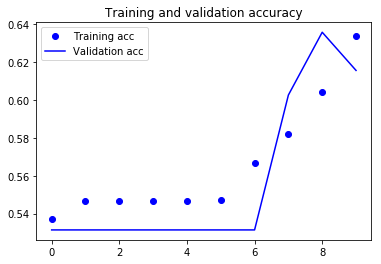

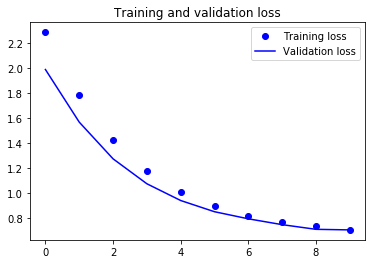

In [16]:
import matplotlib.pyplot as plt 
acc = history_useful_binary.history['acc']

val_acc = history_useful_binary.history['val_acc']
loss = history_useful_binary.history['loss']
val_loss = history_useful_binary.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
loss_ub, mse_ub, acc_ub = model_useful_binary.evaluate(X_test_useful_binary, Y_test_useful_binary, verbose = 2, batch_size = batch_size)

In [18]:
print(loss_ub) #binary cross entropy
print(mse_ub)
print(acc_ub)

0.7017408097874035
0.2363265672055158
0.6121212116877238


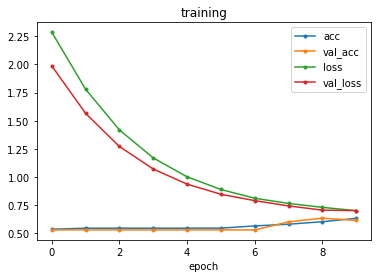

In [19]:
import matplotlib.pyplot as plt

plt.plot(history_useful_binary.history['acc'], '.-')
plt.plot(history_useful_binary.history['val_acc'], '.-')
plt.plot(history_useful_binary.history['loss'], '.-')
plt.plot(history_useful_binary.history['val_loss'], '.-')

plt.title('training')
plt.xlabel('epoch')
plt.legend(['acc','val_acc','loss','val_loss'], loc='best')

del plt

In [0]:
y_pred = model_useful_binary.predict(X_test_useful_binary[0:200])


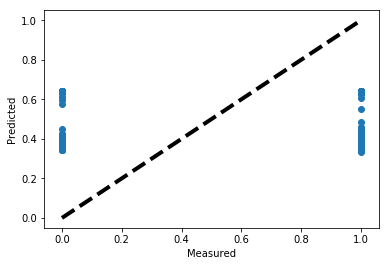

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Y_test_useful_binary[0:200], y_pred)
ax.plot([Y_test_useful_binary[0:200].min(), Y_test_useful_binary[0:200].max()], [Y_test_useful_binary[0:200].min(), Y_test_useful_binary[0:200].max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()